# Survival *lifelines*
[https://lifelines.readthedocs.io/](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html)

In [91]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
os.chdir("/home/jovyan/work/phd/datasets/cancers/lung")

In [207]:
df_files = pd.read_csv("files.txt", sep="\t").set_index("file_name").dropna(how="all", thresh=5, axis=1)

#df_files = pd.read_csv("files.dat", sep=",",index_col=0).dropna(how="all", thresh=100, axis=1)
#df_files = df_files[df_files["dataset"]=="tcga"]
df_files.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1145 entries, 1142583c-2ca0-4f95-a94b-6f1a35ab1580.FPKM.txt.gz to e30a275e-eaf3-43d4-b29c-dc75d77a0c9e.FPKM.txt.gz
Data columns (total 13 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   cases.0.demographic.days_to_birth              1098 non-null   float64
 1   cases.0.demographic.days_to_death              456 non-null    float64
 2   cases.0.demographic.gender                     1145 non-null   object 
 3   cases.0.demographic.vital_status               1145 non-null   object 
 4   cases.0.diagnoses.0.age_at_diagnosis           1098 non-null   float64
 5   cases.0.diagnoses.0.days_to_last_follow_up     869 non-null    float64
 6   cases.0.diagnoses.0.last_known_disease_status  1145 non-null   object 
 7   cases.0.diagnoses.0.tumor_stage                1145 non-null   object 
 8   cases.0.exposures.0.cigarettes_per_day    

In [208]:
df_files["cases.0.diagnoses.0.last_known_disease_status"].unique()

array(['not reported'], dtype=object)

In [209]:
bins = np.linspace(0,100,20)
avg = df_files["cases.0.diagnoses.0.age_at_diagnosis"].mean(skipna=True)
df_files["age_at_diagnosis"]=pd.cut(df_files["cases.0.diagnoses.0.age_at_diagnosis"].fillna(avg)/365., bins=bins, labels = (bins[1:]+bins[:-1])/2).__array__()

In [210]:
df_files["gender"] = (df_files["cases.0.demographic.gender"]=="male").astype(int)

In [211]:
for letter in ["a", "b"]:
    for (old, new) in zip(["stage %s%s"%(i,letter) for i in ["i", "ii", "iii", "iv"]],["stage %s"%i for i in ["i", "ii", "iii", "iv"]]):
        df_files.replace(old, new, inplace=True)
df_files["cases.0.diagnoses.0.tumor_stage"].unique()

array(['stage iii', 'stage i', 'stage ii', 'stage iv', 'not reported'],
      dtype=object)

In [212]:
df_files["tumor_stage"]=df_files["cases.0.diagnoses.0.tumor_stage"]
for i,stage in enumerate(["stage i", "stage ii", "stage iii", "stage iv", "stage v"]):
    df_files["tumor_stage"].replace(stage, i+1, inplace=True)

In [213]:
#1 = Alive
df_files["vital_status"]=(df_files["cases.0.demographic.vital_status"]=="Dead").astype(int)

['not reported']


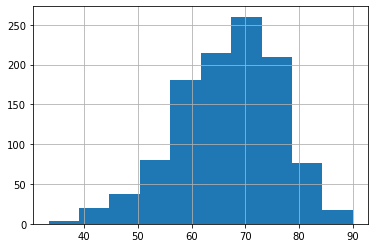

In [214]:
print(df_files["cases.0.diagnoses.0.last_known_disease_status"].unique())
(df_files["cases.0.diagnoses.0.age_at_diagnosis"]/365).hist()

In [215]:
def get_survival(case):
    if case["cases.0.demographic.vital_status"] == 1:
        return case["cases.0.demographic.days_to_death"]
    else:
        return case["cases.0.diagnoses.0.days_to_last_follow_up"]

df_files["days_survival"] = df_files.apply(get_survival,1)

In [216]:
bins = np.linspace(0,100,10)
df_files["smoke"] = pd.cut(df_files["cases.0.exposures.0.years_smoked"], bins=bins, labels = (bins[1:]+bins[:-1])/2 ).__array__()
df_files["smoke"].fillna(0, inplace=True)

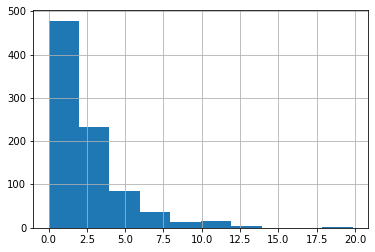

In [217]:
(df_files["days_survival"]/365).hist()

In [218]:
subset = df_files[~df_files["days_survival"].isna()].sample(80)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  app.launch_new_instance()


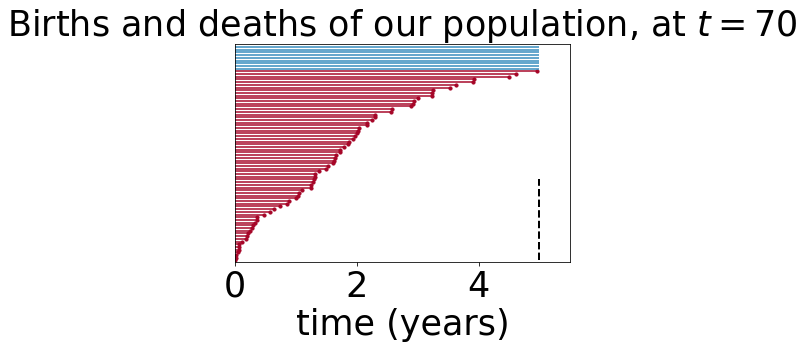

In [219]:
from lifelines.plotting import plot_lifetimes

CURRENT_TIME = 5

actual_lifetimes = subset["days_survival"].to_numpy()/365
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME

ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed, figsize=(18,15))

ax.set_xlim(0, CURRENT_TIME*1.1)
ax.vlines(CURRENT_TIME, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("time (years)", fontsize=35)
ax.tick_params(labelsize=35)
ax.set_title("Births and deaths of our population, at $t=70$", fontsize=35)
plt.tight_layout()
#print("Observed lifetimes at time %d:\n" % (CURRENT_TIME), observed_lifetimes)

In [220]:
subset = df_files[~df_files["days_survival"].isna()]
data = {}
data["duration"]=subset["days_survival"]/365
data["observed"]=subset["vital_status"]
data["entry"]=subset["cases.0.demographic.days_to_birth"]/365

In [221]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [222]:
df_files["vital_status"].sum()

465

In [223]:
T = data["duration"]
E = data["observed"]
entry = data["entry"]

(0.0, 15.0)

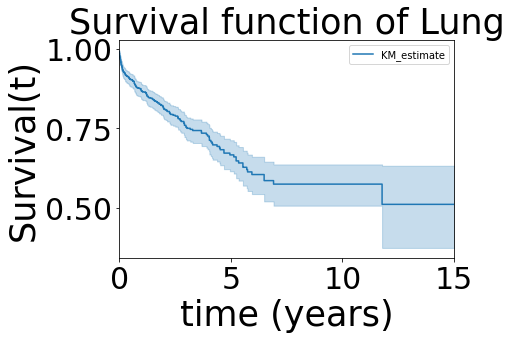

In [224]:
kmf.fit(T, event_observed=E)
ax = kmf.plot()

ax.set_title('Survival function of Lung', fontsize=35)
ax.set_xlabel("time (years)", fontsize=35)
ax.set_ylabel("Survival(t)", fontsize=35)
ax.tick_params(labelsize=30)
ax.set_xlim(0,15)

In [225]:
from lifelines.utils import median_survival_times
median_ci = median_survival_times(kmf.confidence_interval_)
print(kmf.median_survival_time_, "+-", median_ci)

inf +-      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5               11.778082                     inf


Text(0.5, 1.0, 'Survival of different cancer types')

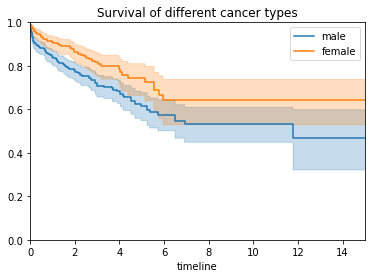

In [226]:
ax = plt.subplot(111)

mask = (subset["cases.0.demographic.gender"]=="male")

kmf.fit(T[mask], event_observed=E[mask], label="male")
kmf.plot(ax=ax)

kmf.fit(T[~mask], event_observed=E[~mask], label="female")
kmf.plot(ax=ax)

plt.ylim(0, 1)
plt.xlim(0,15)
plt.title("Survival of different cancer types")

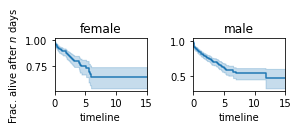

In [227]:
key = 'cases.0.demographic.gender'
labels = subset[key].unique()

for i, label in enumerate(np.sort(labels)):
    ax = plt.subplot(3, 3, i + 1)

    ix = subset[key] == label
    kmf.fit(T[ix], E[ix], label=label)
    kmf.plot(ax=ax, legend=False)

    plt.title(label)
    plt.xlim(0, 15)

    if i==0:
        plt.ylabel('Frac. alive after $n$ days')

plt.tight_layout()

In [274]:
import importlib, survival
importlib.reload(survival)
from survival import fit_cox, add_group_to_subset, save_plot

In [266]:
df_clusters = pd.read_csv("topsbm/topsbm_level_1_topic-dist.csv",index_col=1).drop("i_doc",1)
df_clusters = pd.read_csv("lda/lda_level_2_topic-dist.csv",index_col=1).drop("i_doc",1)

#df_clusters = pd.read_csv("topsbm/topsbm_level_1_topic-dist.csv",index_col=1).drop("i_doc",1)
#df_clusters = df_clusters[df_clusters.index.isin(filter(lambda doc: "GTEX" not in doc,df_clusters.index))]

In [267]:
df_files.head(2)

,cases.0.demographic.days_to_birth,cases.0.demographic.days_to_death,cases.0.demographic.gender,cases.0.demographic.vital_status,cases.0.diagnoses.0.age_at_diagnosis,cases.0.diagnoses.0.days_to_last_follow_up,cases.0.diagnoses.0.last_known_disease_status,cases.0.diagnoses.0.tumor_stage,cases.0.exposures.0.cigarettes_per_day,cases.0.exposures.0.years_smoked,cases.0.project.project_id,cases.0.submitter_id,id,age_at_diagnosis,gender,tumor_stage,vital_status,days_survival,smoke
file_name,,,,,,,,,,,,,,,,,,,
1142583c-2ca0-4f95-a94b-6f1a35ab1580.FPKM.txt.gz,-19088.0,444.0,male,Dead,19088.0,26.0,not reported,stage iii,1.972603,NaN,TCGA-LUAD,TCGA-86-8359,b6b856ca-d5b2-4589-95ec-6495d61fc2fd,50.0,1,3,1,26.0,0.000000
ab51cccb-b5df-434a-a5a4-32368ccf0b24.FPKM.txt.gz,-18856.0,761.0,male,Dead,18856.0,246.0,not reported,stage i,3.287671,30.0,TCGA-LUAD,TCGA-44-2668,e557764a-1399-4143-a2f5-d90359d746bc,50.0,1,1,1,246.0,27.777778


142
Too low -log2(p): -0.0
43
Too low -log2(p): -0.0
19
Too low -log2(p): -0.0
27
Too low -log2(p): -0.0
30
Too low -log2(p): -0.0
29
Too low -log2(p): 0.08295133615423239
89
Too low -log2(p): -0.0
22
Too low -log2(p): -0.0
71
Too low -log2(p): -0.0
104
Too low -log2(p): -0.0
18
Too low -log2(p): -0.0
123
Too low -log2(p): 0.6015450552734452
105
Too low -log2(p): -0.0
19
Too low -log2(p): -0.0
134
Too low -log2(p): -0.0
103
Too low -log2(p): -0.0
129
Too low -log2(p): -0.0
122
TCGA-LUAD :  Topic 18 
 coef    0.439074
p       0.061420
Name: Topic_18, dtype: float64 

96
Too low -log2(p): -0.0
137
Too low -log2(p): -0.0
112
Too low -log2(p): -0.0
54
Too low -log2(p): 0.7061242991403649
65
Too low -log2(p): -0.0
98
Too low -log2(p): 0.6253431207442539
56
Too low -log2(p): -0.0
133
TCGA-LUAD :  Topic 26 
 coef    0.383182
p       0.102736
Name: Topic_26, dtype: float64 

10
Too low -log2(p): 0.5109848159894776
103
TCGA-LUSC :  Topic 2 
 coef    0.431327
p       0.027186
Name: Topic_2, dtyp

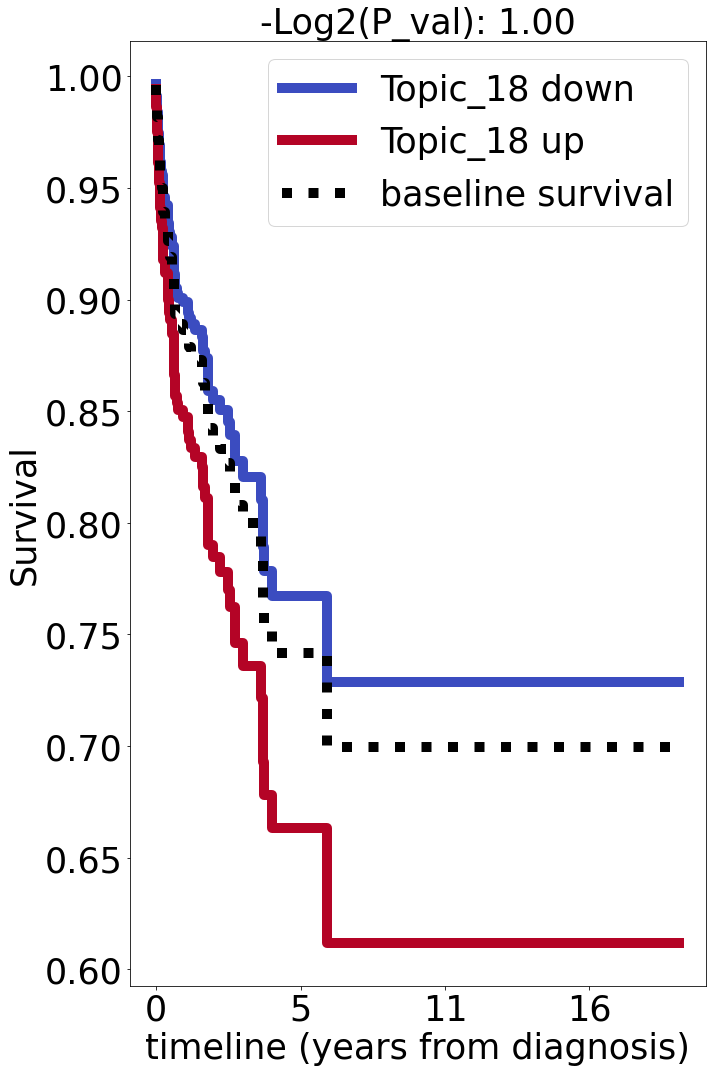

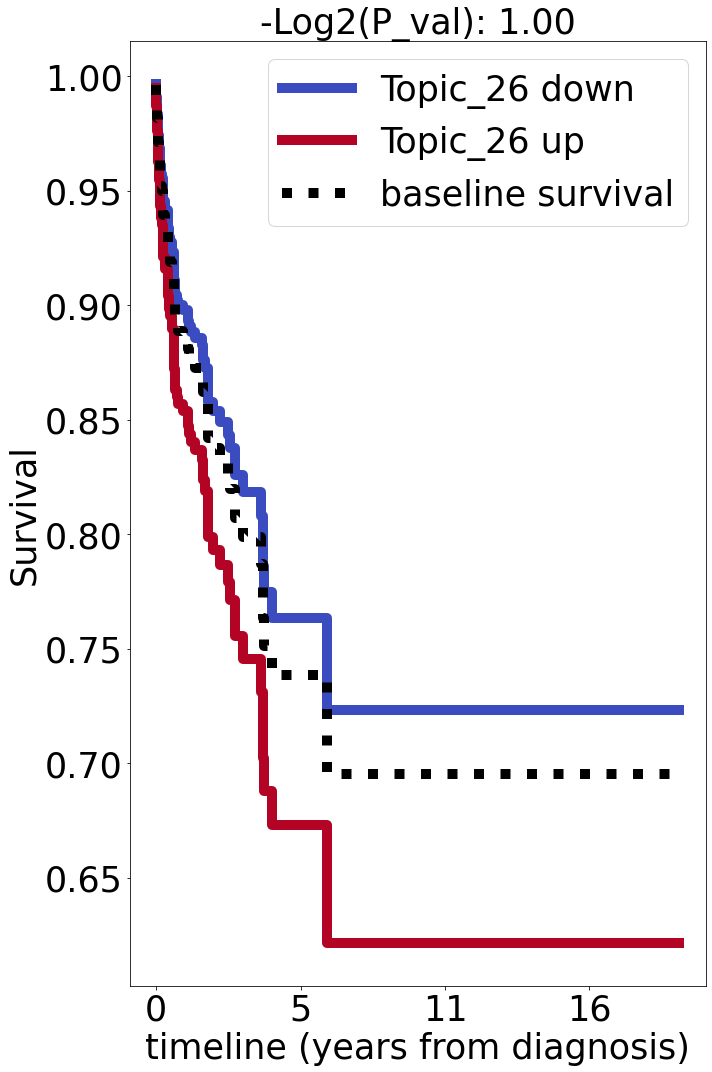

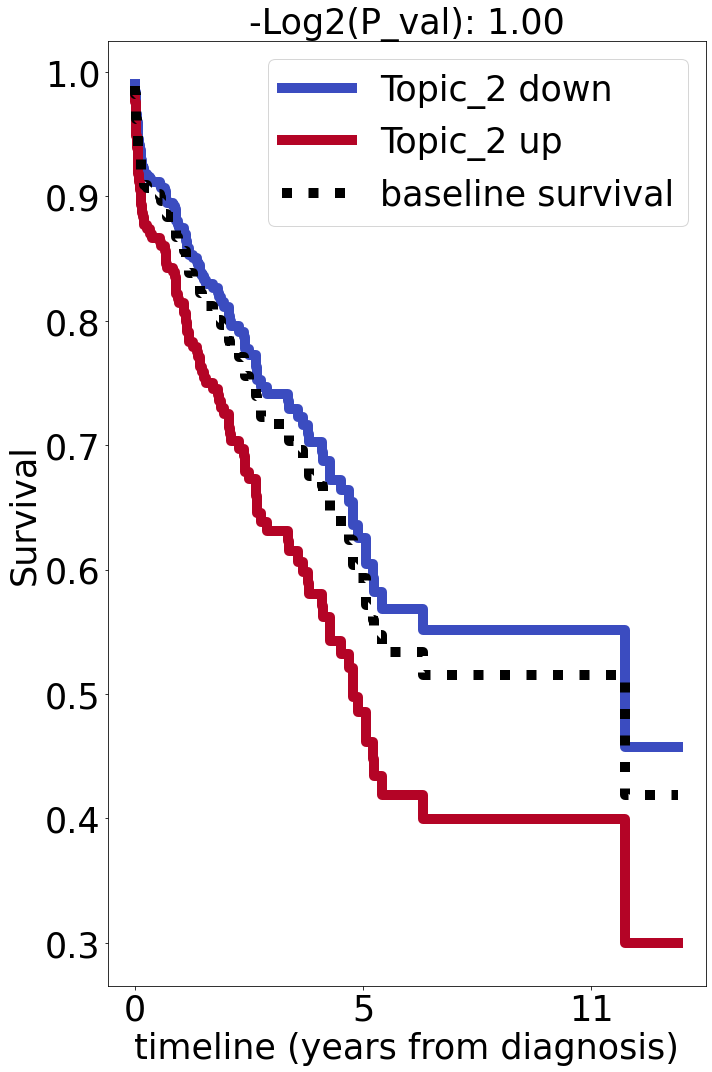

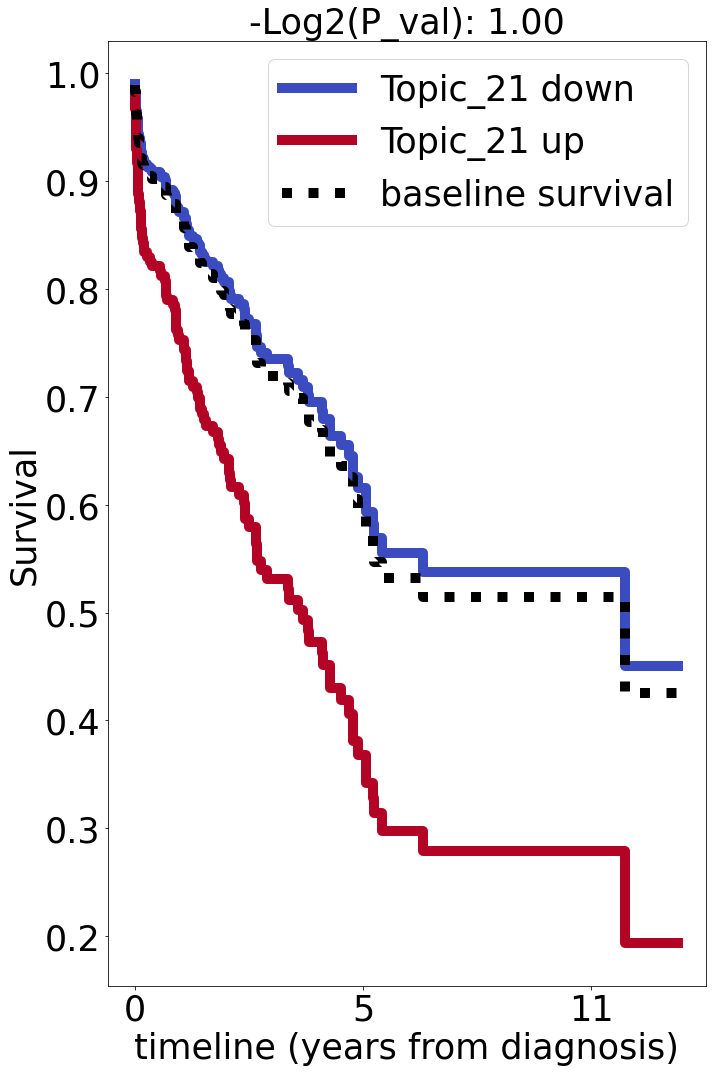

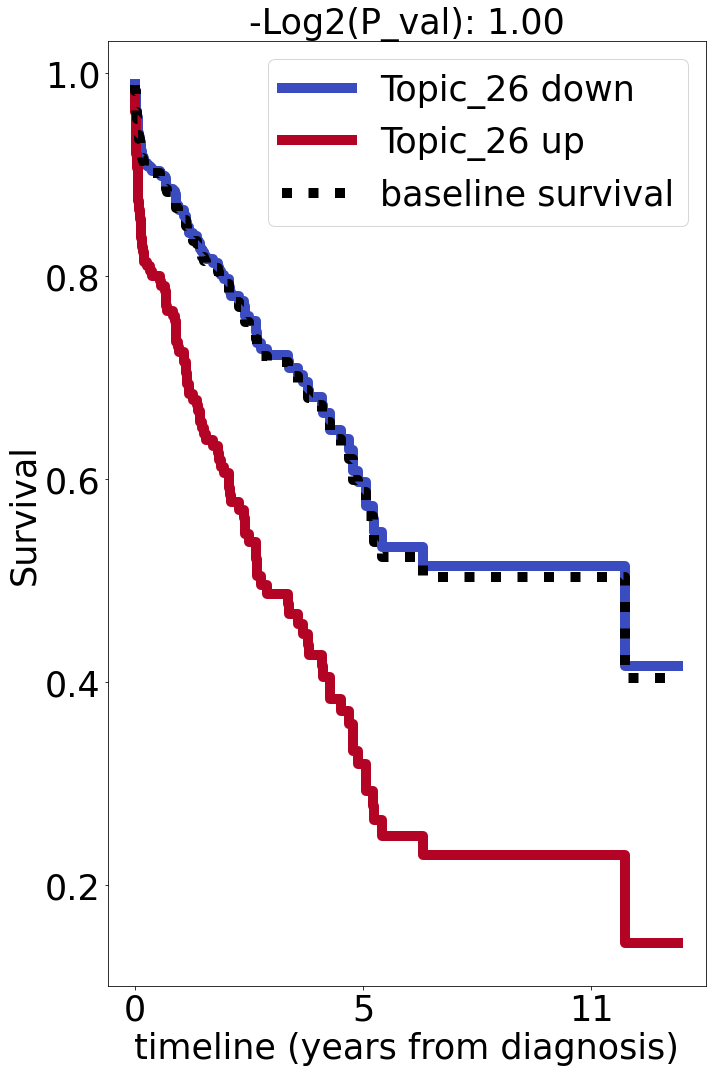

In [275]:
for dataset in ["TCGA-LUAD", "TCGA-LUSC"]:
    mask = (~df_files["days_survival"].isna()) & (df_files["cases.0.diagnoses.0.tumor_stage"]!="not reported") & (df_files["cases.0.project.project_id"]==dataset)
    subset = df_files[mask]
    subset = subset[["days_survival","vital_status","gender", "tumor_stage", "age_at_diagnosis"]]
    for topic in df_clusters.columns:
        top_set = add_group_to_subset(topic, subset, df_clusters, 0.5)
        print(top_set["group"].sum())
        summary, _, ax = fit_cox(top_set, topic)
        if summary is not None:
            if summary.at[summary.index[-1],"-log2(p)"] > 3:
                print(dataset,": ",topic,"\n",summary.loc[summary.index[-1],["coef", "p"]],"\n")
        if ax is not None:
            ax.set_title(dataset+" "+ax.title.get_text(), fontsize=35)
            save_plot(ax, dataset, topic)

                      coef  exp(coef)         p  -log2(p)  corrected_p  \
gender            0.341169   1.406591  0.127998  2.965810     0.511991   
tumor_stage       0.274486   1.315855  0.022441  5.477746     0.089762   
age_at_diagnosis  0.030686   1.031162  0.009788  6.674802     0.039151   
Topic_3           0.796079   2.216832  0.018296  5.772297     0.073186   

                  -log2(corrected_p)  
gender                      0.965810  
tumor_stage                 3.477746  
age_at_diagnosis            4.674802  
Topic_3                     3.772297  


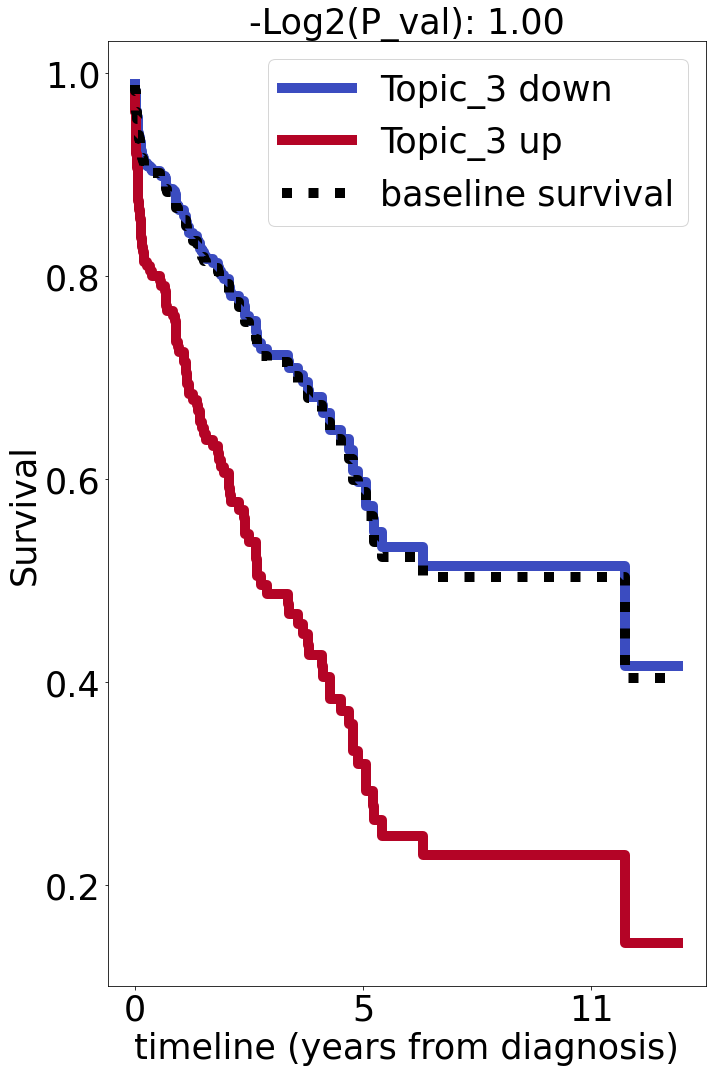

In [276]:
summary, _, ax = fit_cox(top_set, "Topic 3")
print(summary[["coef", "exp(coef)", "p", "-log2(p)", "corrected_p", "-log2(corrected_p)"]])
save_plot(ax, "all", "Topic 3")

In [30]:
for g in pd.read_csv("datasets/cancers/lung/lda/lda_level_2_topics.csv",index_col=1)["Topic 18"].values:
    print(g[:15])

ENSG00000269981
ENSG00000185619
ENSG00000139329
ENSG00000127399
ENSG00000127329
ENSG00000116741
ENSG00000125740
ENSG00000090339
ENSG00000163251
ENSG00000163406
ENSG00000099998
ENSG00000163141
ENSG00000138207
ENSG00000008853
ENSG00000270157
ENSG00000136379
ENSG00000102575
ENSG00000076641
ENSG00000227671
ENSG00000074527
ENSG00000136167


In [31]:
(pd.read_csv("datasets/cancers/lung/topsbm/topsbm_level_1_topics.csv",index_col=1)=="ENSG00000121552").any()

Topic 1     False
Topic 3     False
Topic 4     False
Topic 5     False
Topic 6     False
Topic 7     False
Topic 8     False
Topic 9     False
Topic 10    False
Topic 11    False
Topic 12    False
dtype: bool